### imports

In [20]:
import random
import os
import csv
import tqdm

import numpy as np

from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.cm as cm
from matplotlib.ticker import MaxNLocator
from collections import defaultdict

import clip
import nltk

import torch
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms as T
import torchvision.models as models
from sklearn.model_selection import train_test_split

import kagglehub

In [21]:
class Colour:
    BLUE = '\033[94m'
    CYAN = '\033[96m'
    GREEN = '\033[92m'
    YELLOW = '\033[93m'
    RED = '\033[91m'
    BOLD = '\033[1m'
    END = '\033[0m'

vscode_bg = '#1e1e1e'
text_color = 'white'
grid_color = '#444444'

plt.rcParams['font.family'] = 'monospace'
plt.rcParams['font.monospace'] = ['Consolas', 'DejaVu Sans Mono', 'Courier New']
plt.rcParams['figure.facecolor'] = vscode_bg
plt.rcParams['axes.facecolor'] = vscode_bg
plt.rcParams['axes.edgecolor'] = text_color
plt.rcParams['axes.labelcolor'] = text_color
plt.rcParams['xtick.color'] = text_color
plt.rcParams['ytick.color'] = text_color
plt.rcParams['text.color'] = text_color
plt.rcParams['grid.color'] = grid_color

### load data

In [22]:
path = kagglehub.dataset_download("eeshawn/flickr30k")
print("Path to dataset files:", path)
nltk.download('punkt_tab')

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

Path to dataset files: /Users/valentin/.cache/kagglehub/datasets/eeshawn/flickr30k/versions/1


[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/valentin/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


# Preprocess

### prepare data

In [23]:
class Vocab:
    def __init__(self):
        self.word2idx = {}
        self.idx2word = {}
        self.idx = 0
        # specials tokens
        self.add_word('<pad>')
        self.add_word('<unk>')
        self.add_word('<start>')
        self.add_word('<end>')

    def add_word(self, word):
        if word not in self.word2idx:
            self.word2idx[word] = self.idx
            self.idx2word[self.idx] = word
            self.idx += 1

    def __len__(self):
        return len(self.word2idx)

    def encode(self, text):
        tokens = nltk.tokenize.word_tokenize(text.lower())
        return [self.word2idx.get(t, self.word2idx['<unk>']) for t in tokens]

In [24]:
class CaptionDataset(Dataset):
    def __init__(self, data_pairs, vocab, cache_dir):
        self.data_pairs = data_pairs
        self.vocab = vocab
        self.cache_dir = cache_dir
        
    def __len__(self): return len(self.data_pairs)
    
    def __getitem__(self, idx):
        img_path, caption = self.data_pairs[idx]
        filename = os.path.basename(img_path).split('.')[0] + ".pt"
        load_path = os.path.join(self.cache_dir, filename)
        
        try:
            cached = torch.load(load_path)
            feat = cached['features'] if isinstance(cached, dict) else cached
            if len(feat.shape) > 1: feat = feat[0]
        except FileNotFoundError:
            feat = torch.zeros(512) # fallback

        tokens = self.vocab.encode(caption)
        caption_indices = [self.vocab.word2idx['<start>']] + tokens + [self.vocab.word2idx['<end>']]
        return feat, torch.tensor(caption_indices, dtype=torch.long)

In [25]:
class DataManager:
    def __init__(self, dataset_path, img_folder_name="flickr30k_images", captions_filename="captions.txt", cache_dir="cached_features"):
        self.root = dataset_path
        self.img_folder = os.path.join(self.root, img_folder_name)
        self.captions_file = self._find_file(captions_filename)
        self.token_file = os.path.join(self.root, "flickr30k.token.txt")
        self.cache_dir = cache_dir
        self.vocab = Vocab()
        self.data_pairs = []
        
    def _find_file(self, name):
        for root, _, files in os.walk(self.root):
            if name in files: return os.path.join(root, name)
        return None

    def prepare_data(self, limit=None, vocab_max_size=None):
        """Pipeline complet : CSV -> Token -> Vocab -> Pairs"""
        if not os.path.exists(self.token_file):
            self._convert_csv_to_token()
            
        with open(self.token_file, 'r', encoding='utf-8') as f:
            lines = f.readlines()
            
        random.seed(42)
        random.shuffle(lines)
        
        count = 0
        for line in lines:
            if limit and count >= limit: break
            
            parts = line.strip().split('\t')
            if len(parts) < 2: continue
            
            img_id = parts[0].split('#')[0]
            caption = parts[1]
            img_path = os.path.join(self.img_folder, img_id)
            
            if os.path.exists(img_path):
                self.data_pairs.append((img_path, caption))
                for w in nltk.tokenize.word_tokenize(caption.lower()):
                    if vocab_max_size and len(self.vocab) >= vocab_max_size: continue
                    self.vocab.add_word(w)
                count += 1
                
        print(f"{Colour.GREEN}✅ Data loaded:{Colour.END} {Colour.BOLD}{len(self.data_pairs)}{Colour.END} pairs | {Colour.BOLD}{len(self.vocab)}{Colour.END} vocab words")

    def _convert_csv_to_token(self):
        try:
            with open(self.captions_file, 'r', encoding='utf-8') as infile, \
                 open(self.token_file, 'w', encoding='utf-8') as outfile:
                reader = csv.reader(infile)
                next(reader)
                for row in reader:
                    if len(row) == 3:
                        outfile.write(f"{row[0]}#{row[1]}\t{row[2]}\n")
        except Exception as e:
            print(f"{Colour.RED}❌ Conversion error:{Colour.END} {e}")
    
    def caption_collate_fn(self, batch):
        imgs, caps = zip(*batch)
        imgs = torch.stack(imgs)
        caps_padded = pad_sequence(caps, batch_first=True, padding_value=0)
        return imgs, caps_padded

    def get_loaders(self, batch_size=64, test_size=0.2):
        """Divise par IMAGE et renvoie les DataLoaders"""
        img_to_caps = {}
        for img, cap in self.data_pairs:
            if img not in img_to_caps: img_to_caps[img] = []
            img_to_caps[img].append(cap)
            
        unique_imgs = list(img_to_caps.keys())
        train_imgs, test_imgs = train_test_split(unique_imgs, test_size=test_size, random_state=42)
        
        train_pairs = [(img, cap) for img in train_imgs for cap in img_to_caps[img]]
        test_pairs = [(img, cap) for img in test_imgs for cap in img_to_caps[img]]
        
        print(f"{Colour.CYAN}📊 Split:{Colour.END} Train {Colour.BOLD}{len(train_pairs)}{Colour.END} | Test {Colour.BOLD}{len(test_pairs)}{Colour.END}")
        
        train_ds = CaptionDataset(train_pairs, self.vocab, self.cache_dir)
        test_ds = CaptionDataset(test_pairs, self.vocab, self.cache_dir)
        
        train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, collate_fn=self.caption_collate_fn, drop_last=True)
        test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False, collate_fn=self.caption_collate_fn, drop_last=True)
        
        return train_loader, test_loader, train_pairs, test_pairs


In [26]:
data_manager = DataManager(path)
data_manager.prepare_data(limit=26000, vocab_max_size=5000)
train_loader, test_loader, train_pairs, test_pairs = data_manager.get_loaders(batch_size=100)
vocab = data_manager.vocab

✅ Data loaded: 26000 pairs | 5000 vocab words
📊 Split: Train 20855 | Test 5145


# Useful functions

### alignment computation

In [27]:
def get_alignment(img_path, detector, model_align, preprocess_align, device, threshold=0.5):
    img_pil = Image.open(img_path).convert("RGB")
    w_img, h_img = img_pil.size
    img_tensor = T.ToTensor()(img_pil).to(device)
    
    with torch.no_grad():
        pred = detector([img_tensor])[0]
        
    keep_score = pred['scores'] > threshold
    boxes = pred['boxes'][keep_score]
    scores = pred['scores'][keep_score]
    
    keep_nms = torchvision.ops.nms(boxes, scores, 0.3)
    final_boxes = boxes[keep_nms][:19]
    crops_tensors = [preprocess_align(img_pil)]

    for box in final_boxes:
        x1, y1, x2, y2 = box.int().tolist()
        x1, y1 = max(0, x1), max(0, y1)
        x2, y2 = min(w_img, x2), min(h_img, y2)
        if x2 - x1 < 1 or y2 - y1 < 1:
            continue
        crop = img_pil.crop((x1, y1, x2, y2))
        crops_tensors.append(preprocess_align(crop))

    batch_input = torch.stack(crops_tensors).to(device)

    with torch.no_grad():
        batch_features = model_align.encode_image(batch_input)
    
    regions_features = [feat.cpu().float().numpy().flatten() for feat in batch_features]
    return regions_features, final_boxes

### visualization

In [28]:
def visualize_alignment(img_path, caption, detector, model_align, preprocess_align, device, threshold=0.5, dist_test=20):
    region_feats, boxes = get_alignment(img_path, detector, model_align, preprocess_align, device, threshold)
    
    if not boxes.shape[0]:
        print(f"{Colour.RED}no objects detected in image.{Colour.END}")
        return

    img_features = torch.tensor(np.array(region_feats)).to(device)
    img_features /= img_features.norm(dim=-1, keepdim=True)

    words = nltk.word_tokenize(caption.lower())
    stop_words = {'.', ',', 'a', 'the', 'is', 'are', 'in', 'on', 'of', 'and', 'with', 'to', 'at'}
    meaningful_words = [w for w in words if w not in stop_words]
    meaningful_words.reverse()      # test
    
    if not meaningful_words:
        print(f"{Colour.YELLOW}no meaningful words found after filtering.{Colour.END}")
        return

    with torch.no_grad():
        text_tokens = clip.tokenize(meaningful_words).to(device)
        text_features = model_align.encode_text(text_tokens)
        text_features /= text_features.norm(dim=-1, keepdim=True)

    similarity = (100.0 * img_features @ text_features.T).softmax(dim=0).cpu().numpy()
    best_indices = similarity.argmax(axis=0)
    best_scores = similarity.max(axis=0)

    img_pil = Image.open(img_path).convert("RGB")
    w_img, h_img = img_pil.size
    
    fig, ax = plt.subplots(figsize=(14, 8), facecolor=vscode_bg)
    ax.set_facecolor(vscode_bg)

    ax.imshow(img_pil)
    
    colors = cm.tab20(range(len(meaningful_words)))
    text_x_start = w_img + (w_img * 0.05)

    for i, (word, best_idx, score) in enumerate(zip(meaningful_words, best_indices, best_scores)):
        color = colors[i]
        
        if best_idx == 0:
            target_x, target_y = w_img / 2, h_img / 2
        else:
            box_idx = best_idx - 1 
            box = boxes[box_idx].cpu().numpy() if isinstance(boxes[box_idx], torch.Tensor) else boxes[box_idx]
            x1, y1, x2, y2 = box
            
            rect = patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=2.5, edgecolor=color, facecolor='none')
            ax.add_patch(rect)
            target_x, target_y = (x1 + x2) / 2, (y1 + y2) / 2
        text_y = (i * dist_test) + (h_img * 0.05)
        label_text = f"{word} ({score:.2f})"
        ax.text(text_x_start, text_y, label_text, 
                fontsize=13, fontweight='bold', color='black', 
                va='center', ha='left', family='monospace',
                bbox=dict(boxstyle='square,pad=0.4', facecolor=color, edgecolor='none', alpha=0.9))

        if score > 0.1: # threshold to draw arrow
            ax.annotate('', 
                        xy=(target_x, target_y), 
                        xytext=(text_x_start, text_y),
                        arrowprops=dict(arrowstyle='->', color=color, linewidth=2, mutation_scale=15))

    ax.set_xlim(0, w_img * 1.6) 
    ax.set_ylim(h_img, 0) # flip Y to match image coordinates
    ax.axis("off")
    
    plt.tight_layout()
    plt.show()

In [29]:
model_align, preprocess_align = clip.load("ViT-B/32", device=DEVICE)
model_align.eval()

weights = torchvision.models.detection.FasterRCNN_ResNet50_FPN_Weights.DEFAULT
resnet = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights=weights).to(DEVICE)   # pretrained=True
resnet.eval()

print(f"{Colour.GREEN}✅ Models loaded{Colour.END}")
print(f"💻 Device: {Colour.YELLOW}{DEVICE.upper()}{Colour.END}")

✅ Models loaded
💻 Device: CPU


# Load model

In [30]:
class CaptioningModel(nn.Module):
    def __init__(self, vocab_size, embed_dim, image_feature_dim, hidden_size, dropout_prob=0.5):
        super().__init__()
        self.image_projection = nn.Linear(image_feature_dim, embed_dim)
        self.word_embedding = nn.Embedding(vocab_size, embed_dim)
        self.lstm = nn.LSTM(input_size=embed_dim + embed_dim, hidden_size=hidden_size, batch_first=True)
        self.output_projection = nn.Linear(hidden_size, vocab_size)
        self.dropout = nn.Dropout(dropout_prob)

    def forward(self, image_features, captions):
        img_emb = self.image_projection(image_features) # [Batch, Embed_Dim]
        img_emb = F.relu(img_emb)
        
        word_embeds = self.word_embedding(captions)     # [Batch, Seq_Len, Embed_Dim]
        word_embeds = self.dropout(word_embeds)
        
        seq_len = word_embeds.size(1)
        img_emb_expanded = img_emb.unsqueeze(1).expand(-1, seq_len, -1)
        
        lstm_inputs = torch.cat((word_embeds, img_emb_expanded), dim=2) 
        lstm_out, _ = self.lstm(lstm_inputs)
        
        return self.output_projection(lstm_out)

    def sample(self, image_features, vocab, max_len=20, temperature=1.0, device='cpu'):
        self.eval()
        with torch.no_grad():
            img_emb = self.image_projection(image_features)
            img_emb = F.relu(img_emb)
            img_emb = img_emb.unsqueeze(1) 
            
            hidden = None 
            start_token = vocab.word2idx.get('<start>', vocab.word2idx.get('<unk>', 1))
            current_input_idx = torch.tensor([start_token]).long().to(device).unsqueeze(0) # [1, 1]
            
            generated_ids = []
            
            for i in range(max_len):
                word_emb = self.word_embedding(current_input_idx) # [1, 1, Embed_Dim]

                lstm_input = torch.cat((word_emb, img_emb), dim=2) # [1, 1, Embed_Dim * 2]
                lstm_out, hidden = self.lstm(lstm_input, hidden)
                outputs = self.output_projection(lstm_out) # [1, 1, Vocab]
                
                probs = F.softmax(outputs[0, 0] / temperature, dim=0)
                
                if temperature == 0:
                    next_word_idx = torch.argmax(probs).item()
                else:
                    next_word_idx = torch.multinomial(probs, 1).item()
                
                if next_word_idx == vocab.word2idx.get('<end>', 0):
                    break
                
                generated_ids.append(next_word_idx)
                current_input_idx = torch.tensor([next_word_idx]).long().to(device).unsqueeze(0)
                
            tokens = [vocab.idx2word.get(idx, '<unk>') for idx in generated_ids]
            return " ".join(tokens)

In [31]:
VOCAB_SIZE = len(vocab)
EMBED_DIM = 512
HIDDEN_SIZE = 512
IMG_FEAT_DIM = 2048

In [32]:
file_saved_model = 'saved_models/captioning_model_epoch_60.pth'

checkpoint = torch.load(file_saved_model, map_location=DEVICE)
model_captioning = CaptioningModel(VOCAB_SIZE, EMBED_DIM, IMG_FEAT_DIM, HIDDEN_SIZE).to(DEVICE)
model_captioning.load_state_dict(checkpoint['model_state_dict'])
optimizer_captioning = torch.optim.RMSprop(model_captioning.parameters(), lr=1e-4)
optimizer_captioning.load_state_dict(checkpoint['optimizer_state_dict'])
vocab.word2idx = checkpoint['vocab_word2idx']
vocab.idx2word = checkpoint['vocab_idx2word']
train_losses = checkpoint['train_losses']
epoch = checkpoint['epoch']
print(f"{Colour.GREEN}✅ Pretrained model loaded from {Colour.BOLD}{file_saved_model}{Colour.END}")

criterion_captioning = nn.CrossEntropyLoss(ignore_index=vocab.word2idx.get('<pad>', 0))

print(f"💻 Device: {Colour.YELLOW}{DEVICE.upper()}{Colour.END}")

✅ Pretrained model loaded from saved_models/captioning_model_epoch_60.pth
💻 Device: CPU


# Visualization

In [33]:
def visualize_captioning(data_pairs, vocab, model_captioning, device, cache_dir="cached_features", temperature=1.0):
    model_captioning.eval()
    img_path, true_caption = random.choice(data_pairs)

    filename = os.path.basename(img_path).split('.')[0] + ".pt"
    load_path = os.path.join(cache_dir, filename)
    
    if not os.path.exists(load_path):
        print(f"{Colour.RED}❌ Features not found for: {img_path}{Colour.END}")
        return

    plt.figure(figsize=(10, 8))
    plt.imshow(Image.open(img_path).convert("RGB"))
    plt.axis('off')
    plt.show()

    features = torch.load(load_path)['features']
    img_vector = (features[0] if features.ndim > 1 else features).unsqueeze(0).to(device)
    generated_caption = model_captioning.sample(img_vector, vocab, max_len=20, temperature=temperature, device=device)
    split_label = "TRAIN" if any(p[0] == img_path for p in train_pairs) else "TEST"

    print(f"📁 Split: {Colour.CYAN}{Colour.BOLD}{split_label}{Colour.END}")
    print(f"🔍 Ground truth: {Colour.GREEN}{true_caption}{Colour.END}")
    print(f"🤖 Generated (T={temperature}): {Colour.YELLOW}{Colour.BOLD}{generated_caption}{Colour.END}")

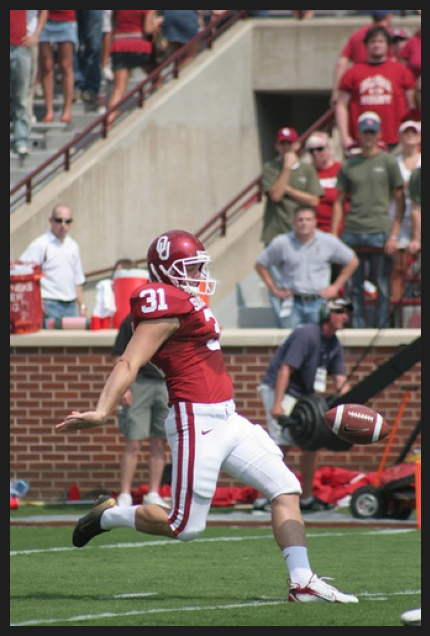

📁 Split: TEST
🔍 Ground truth: An Oklahoma football player attempts to kick the ball .
🤖 Generated (T=0.3): a football player is about to throw the ball .


In [49]:
visualize_captioning(test_pairs, vocab, model_captioning, DEVICE, cache_dir="cached_features", temperature=0.3)

In [35]:
def visualize_captioning_grid(data_pairs, vocab, model_captioning, device, cache_dir="cached_features", temperature=1.0):
    model_captioning.eval()
    size_buckets = defaultdict(list)
    selected_items = [] # will contain tuples: (img_path, true_caption)
    found_dims = None
    
    pairs_shuffled = data_pairs.copy()
    random.shuffle(pairs_shuffled)

    for img_path, true_caption in pairs_shuffled:
        filename = os.path.basename(img_path).split('.')[0] + ".pt"
        load_path = os.path.join(cache_dir, filename)
        
        if not os.path.exists(load_path):
            continue

        try:
            with Image.open(img_path) as img:
                dims = img.size # (width, height)
                size_buckets[dims].append((img_path, true_caption))
                
                if len(size_buckets[dims]) == 4:
                    selected_items = size_buckets[dims]
                    found_dims = dims
                    break
        except Exception:
            continue

    if not selected_items:
        print(f"{Colour.RED}could not find 4 images with matching sizes.{Colour.END}")
        return
    
    text_color = 'white'
    
    fig, axes = plt.subplots(2, 2, figsize=(14, 12), facecolor=vscode_bg)
    # fig.suptitle(f"Model Caption Generation (Temperature: {temperature})", fontsize=18, color=text_color, y=0.98)
    
    generated_results = [] # to store for printing later

    for idx, (img_path, true_caption) in enumerate(selected_items):
        row = idx // 2
        col = idx % 2
        ax = axes[row, col]
        
        ax.set_facecolor(vscode_bg)
        ax.axis('off')
        
        filename = os.path.basename(img_path).split('.')[0] + ".pt"
        load_path = os.path.join(cache_dir, filename)
        features = torch.load(load_path)['features']
        img_vector = (features[0] if features.ndim > 1 else features).unsqueeze(0).to(device)
        
        generated_caption = model_captioning.sample(img_vector, vocab, max_len=20, temperature=temperature, device=device)
        generated_results.append((img_path, true_caption, generated_caption))

        image = Image.open(img_path).convert("RGB")
        ax.imshow(image)
        
        truncated_gen = (generated_caption[:64] + '...') if len(generated_caption) > 64 else generated_caption
        ax.set_title(f"Gen: {truncated_gen}", fontsize=11, color=text_color, pad=10)

    plt.tight_layout()
    plt.show()
    
    print(f"{Colour.BOLD}Detailed Report (True vs Generated):{Colour.END}")
    print(f"{Colour.YELLOW}Temperature = {temperature}{Colour.END}")
    for i, (path, true_cap, gen_cap) in enumerate(generated_results, 1):
        img_id = os.path.basename(path)
        print(f"\n{Colour.CYAN}Image {i}: {img_id}{Colour.END}")
        print(f"  {Colour.GREEN}True :{Colour.END} {true_cap}")
        print(f"  {Colour.YELLOW}Gen  :{Colour.END} {gen_cap}")

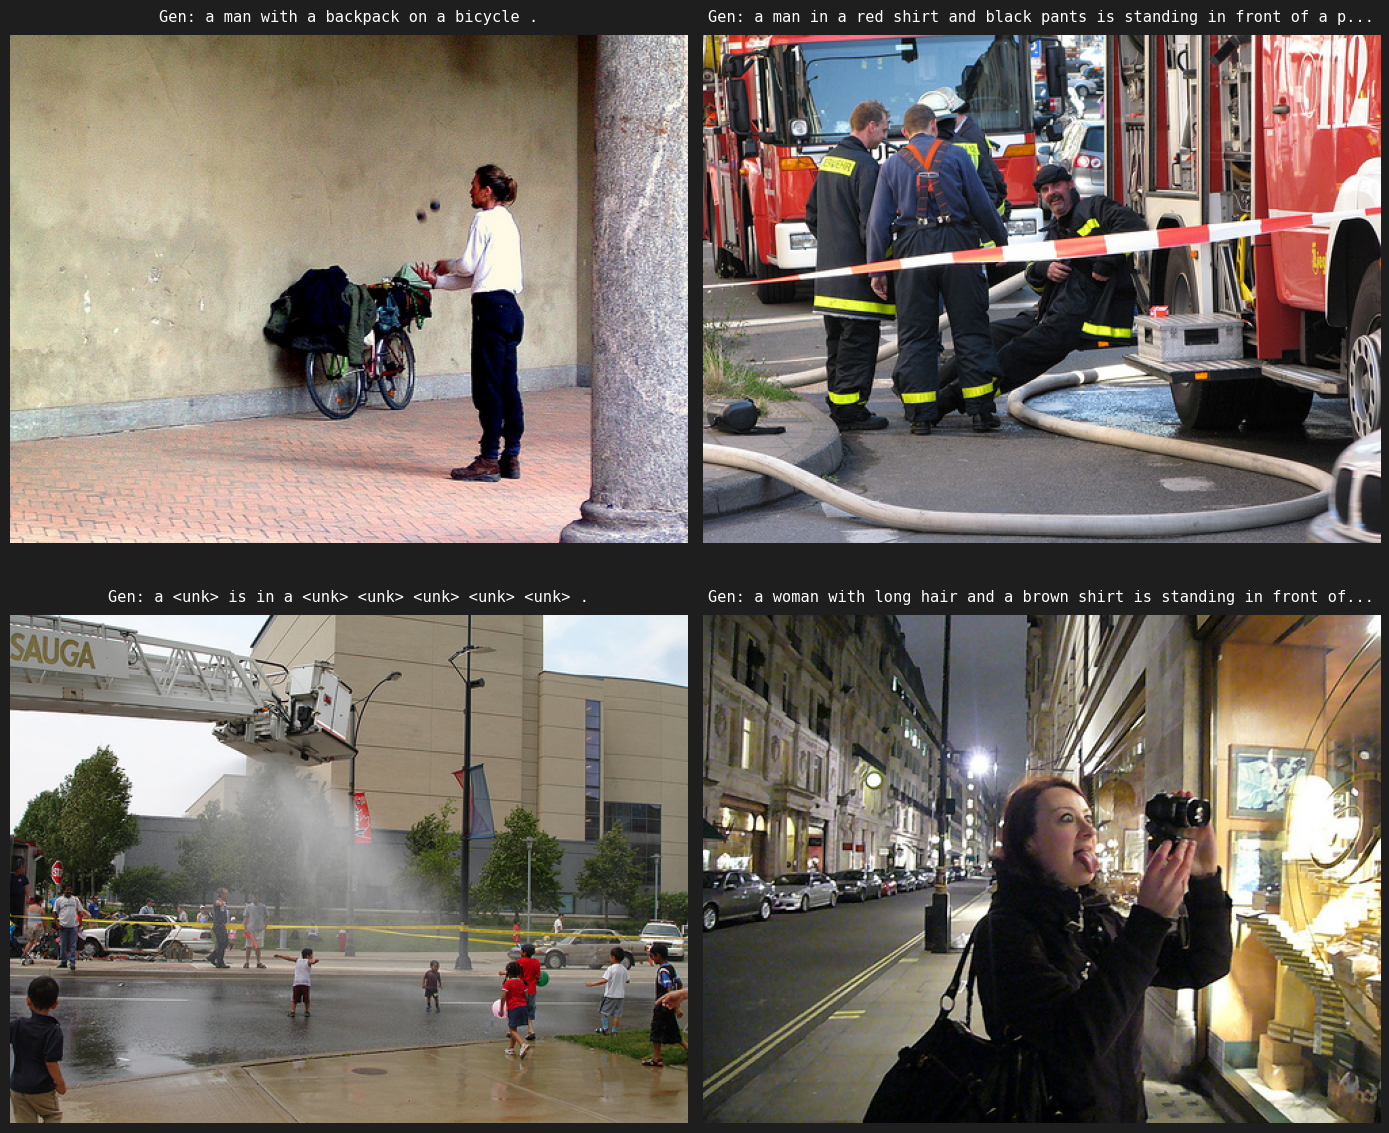

Detailed Report (True vs Generated):
Temperature = 0.5

Image 1: 2747253501.jpg
  True : A person staring at a wall that has a bike against it .
  Gen  : a man with a backpack on a bicycle .

Image 2: 1423335781.jpg
  True : Three firemen are conversing next to a firetruck .
  Gen  : a man in a red shirt and black pants is standing in front of a parking lot .

Image 3: 181103691.jpg
  True : Children playing in water .
  Gen  : a <unk> is in a <unk> <unk> <unk> <unk> <unk> .

Image 4: 3338573401.jpg
  True : A woman opens her eyes wide and sticks her tongue out as she holds a camera to take a picture .
  Gen  : a woman with long hair and a brown shirt is standing in front of a glass with a <unk> of


In [44]:
visualize_captioning_grid(test_pairs, vocab, model_captioning, DEVICE, cache_dir="cached_features", temperature=0.5)

In [37]:
def visualize_alignment_captioning(img_path, vocab, detector, model_align, preprocess_align, model_captioning, device, show_regions=False, temperature=1.0):

    if not os.path.exists(img_path):
        print(f"{Colour.RED}❌ Image not found: {img_path}{Colour.END}")
        return
    
    img_pil = Image.open(img_path).convert("RGB")

    # dimension management
    expected_dim = model_captioning.image_projection.in_features
    if expected_dim == 2048:
        resnet_extractor = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1).to(device)
        resnet_extractor.eval()
        resnet_extractor = nn.Sequential(*list(resnet_extractor.children())[:-1])
        
        preprocess_resnet = T.Compose([T.Resize(256), T.CenterCrop(224), T.ToTensor(), T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])
        img_tensor_resnet = preprocess_resnet(img_pil).unsqueeze(0).to(device)
        with torch.no_grad():
            global_feat_tensor = resnet_extractor(img_tensor_resnet).flatten(start_dim=1)
            
    else:
        region_features_list, _ = get_alignment(img_path, detector, model_align, preprocess_align, device)
        global_feat_numpy = region_features_list[0]
        global_feat_tensor = torch.tensor(global_feat_numpy).float().to(device).unsqueeze(0)

    generated_caption = model_captioning.sample(global_feat_tensor, vocab, max_len=20, temperature=temperature, device=device)
    if show_regions:
        visualize_alignment(img_path, generated_caption, detector, model_align, preprocess_align, device, dist_test=70)

    else:
        plt.figure(figsize=(10, 8))
        plt.imshow(img_pil)
        plt.axis('off')
        plt.tight_layout()
        plt.show()

    print(f"🤖 Generated (T={temperature}) : {Colour.YELLOW}{Colour.BOLD}{generated_caption}{Colour.END}")
    # print(f".   Generated caption : {Colour.YELLOW}{Colour.BOLD}{generated_caption}{Colour.END}")
    

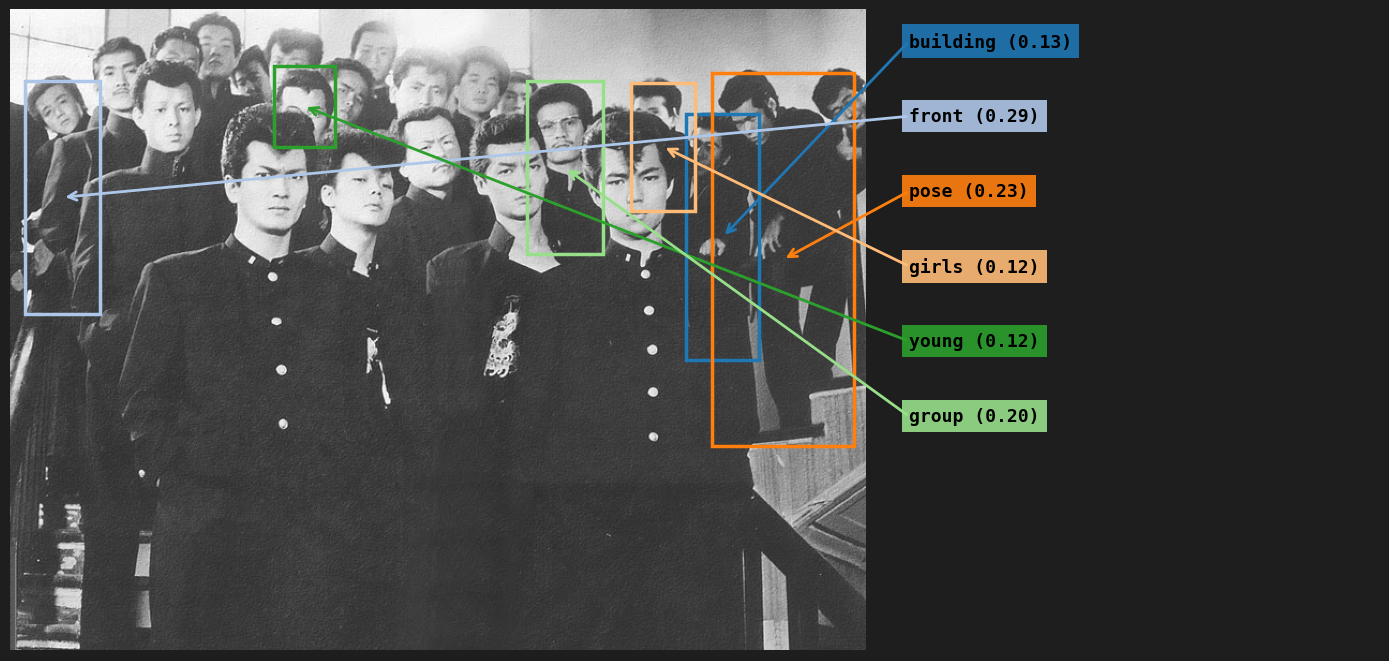

🤖 Generated (T=0.3) : a group of young girls pose in front of a building .


In [38]:
image_path = "images_examples/japanese.jpg"
temperature = 0.3
show_regions = True
visualize_alignment_captioning(img_path=image_path, vocab=vocab, detector=resnet, model_align=model_align, preprocess_align=preprocess_align, model_captioning=model_captioning, device=DEVICE, show_regions=show_regions, temperature=temperature)